In [1]:
import copy, cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from models import regressionnet
from scripts import tools
from scripts import dataset
from scripts.config import *

%matplotlib inline

tools.etc.set_GPU("1")

In [2]:
net_type = 'convnet1'
net, _, _, _ = regressionnet.create_regression_net(data_shape=(227,227,3),optimizer_type='adadelta',num_joints=14,net_type=net_type, gpu_memory_fraction=None)  
with net.graph.as_default():
    saver = tf.train.Saver()
    saver.restore(net.sess, "./snapshots/Convnet4000_new_170/convnet1_gpu3_4000.ckpt")
    test_it = dataset.met("./dataset/test.csv", Fliplr=True, Shuffle=False, dataset_root="./dataset/")

INFO:tensorflow:Restoring parameters from ./snapshots/Convnet4000_new_170/convnet1_gpu3_4000.ckpt


[Mirroring Images & Coordinates]: 100%|██████████| 60/60 [00:00<00:00, 1379.58it/s]


In [3]:
predicted_joints = net.sess.run(
    [net.fc_regression],
    feed_dict={net.x : test_it.img_set, net.keep_prob:1.0})[0]

predicted_joints = predicted_joints.reshape(len(predicted_joints),14,2)
pred_canonical = tools.pose.convert2canonical(predicted_joints)
orig_canonical = tools.pose.convert2canonical(test_it.coor_set)

In [4]:
pcp_value=tools.pose.eval_strict_pcp(orig_canonical,pred_canonical)
average_pcp = tools.pose.average_pcp_left_right_limbs(pcp_value)
for i in range(len(average_pcp[1])):
    print(average_pcp[1][i]+" : "+str(average_pcp[0][i]))

Head : 0.7916666666666666
Torso : 0.9333333333333333
U Arm : 0.8708333333333333
L Arm : 0.7333333333333334
U Leg : 0.8083333333333333
L Leg : 0.8125
mean : 0.8250000000000001


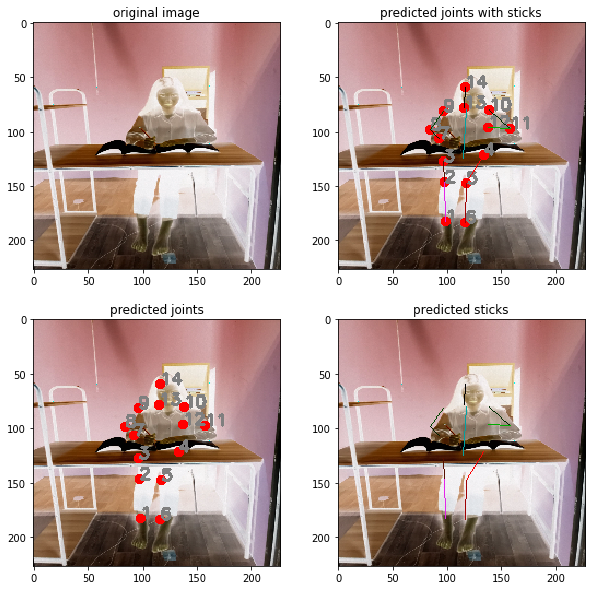

In [5]:
idx=27

pred_img1 = copy.copy(test_it.img_set[idx])
pred_img2 = copy.copy(test_it.img_set[idx])
pred_img3 = copy.copy(test_it.img_set[idx])

pred_joints=tools.etc.markJoints(img=pred_img1, joints=predicted_joints[idx])
pred_sticks=tools.etc.drawSticks(img=pred_img2, sticks=pred_canonical[idx]['sticks'])

pred_joints_with_sticks = tools.etc.markJoints(img=pred_img3, joints=predicted_joints[idx])  
pred_joints_with_sticks = tools.etc.drawSticks(img=pred_img3, sticks=pred_canonical[idx]['sticks'])  

fig, ((p11,p12),(p21,p22)) = plt.subplots(2,2)
fig.set_size_inches(10, 10)

p11.set_title("original image")
p11.imshow(test_it.img_set[idx])
p12.set_title("predicted joints with sticks")
p12.imshow(pred_joints_with_sticks)

p21.set_title("predicted joints")
p21.imshow(pred_img1)
p22.set_title("predicted sticks")
p22.imshow(pred_img2)